# 6. Linear Model Selection and Regularisation – Lab

Excercises from **Chapter 6** of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/) by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import patsy
import itertools
from IPython.display import display, HTML

In [7]:
# Load data
hitters_pd = pd.read_csv('./data/Hitters.csv')

# Drop 59 rows missing data
hitters_pd = hitters_pd.dropna()
assert hitters_pd.isna().sum().sum() == 0

# Create dummy variables for qualitative features
qual = ['League', 'Division', 'NewLeague']
hitters_pd = pd.get_dummies(hitters_pd, columns=qual)

hitters_pd.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,475.0,0,1,0,1,0,1
2,479,130,18,66,72,76,3,1624,457,63,...,880,82,14,480.0,1,0,0,1,1,0
3,496,141,20,65,78,37,11,5628,1575,225,...,200,11,3,500.0,0,1,1,0,0,1
4,321,87,10,39,42,30,2,396,101,12,...,805,40,4,91.5,0,1,1,0,0,1
5,594,169,4,74,51,35,11,4408,1133,19,...,282,421,25,750.0,1,0,0,1,1,0


## Lab 1: Subset Selection Methods

### 6.5.1 Best subset selection

Perform best subset selection by identifying the best model that contains a given number of predictors, where best is quantified using RSS.

In [8]:
def get_models(k, X, y):
    """
    Fit all possible models that contain exactly k predictors.
    """
    # List all available predictors
    X_combos = itertools.combinations(list(X.columns), k)
    
    # Fit all models accumulating Residual Sum of Squares (RSS)
    models = []
    for X_label in X_combos:
        # Parse patsy formula
        X_smf = ' + '.join(X_label)
        f     = 'Salary ~ {}'.format(X_smf)
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        # Return results
        models += [(f, model)]
    return models


def min_rss(statsmodels):
    """Return model with lowest Residual Sum of Squares (RSS)"""
    return sorted(statsmodels, key=lambda tup: tup[1].ssr)[0]


def max_adjr2(statsmodels):
    """Return model with lowest R-squared"""
    return sorted(statsmodels, reverse=True, key=lambda tup: tup[1].rsquared_adj)[0]


### Which model with 2 predictors yields lowest RSS score?

In [9]:
X = hitters_pd.drop('Salary', axis=1)
y = hitters_pd['Salary']

# Set number ofr predictors in subset
k = 2

# Get all possible models in subset
subset = get_models(2, X, y)

# Display results
print('This model yields the lowest RSS score for the subset of models with {} predictors:'.format(k))
display(min_rss(subset))

print('This model yields the highest adjusted R-squared score for the subset of models with {} predictors:'.format(k))
max_adjr2(get_models(2, X, y))

This model yields the lowest RSS score for the subset of models with 2 predictors:


('Salary ~ Hits + CRBI',
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1a1e0f9b00>)

This model yields the highest adjusted R-squared score for the subset of models with 2 predictors:


('Salary ~ Hits + CRBI',
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1a1e7272e8>)

In [14]:
X.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors', 'League_A', 'League_N', 'Division_E', 'Division_W',
       'NewLeague_A', 'NewLeague_N'],
      dtype='object')

The model with 2 predictors that yields the lowest RSS score is the one that uses the predictors 'Hits', and 'CRBI'

### How do the the maximum $R^2$, minimum RSS, and BIC statistics vary for each subset with k predictors? 

First we fit all possible models in each subset of models with k predictors. This turns out to be a very computationally expensive process, running on my laptop for 30 minutes yielded results up to only k=6 and occupied 30GB of memeory. Not suprising as number of possible combinations without repetition is given by:

$\frac{p!}{k!(p-k)!}$

Where *p* is number of predictors to choose from and we choose *k* of them.

In this example p=22, there are 22 predictors.

For k = 4 the number of possible combinations is given by:

$\frac{22!}{4!x 18!} = 74,613$

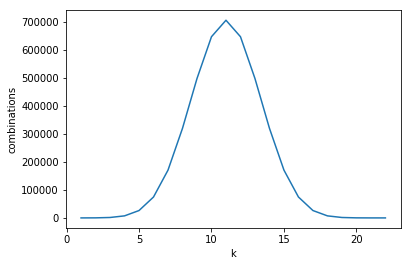

In [34]:
# How does the number of possible combinations of the 22 features vary with k?
# Lets do a quick plot to find out!

from scipy.special import factorial

n = 22
k = np.arange(1, n+1)
y = factorial(n) / (factorial(k)*factorial(n-k))

ax = sns.lineplot(x=k, y=y)
plt.xlabel('k')
plt.ylabel('combinations');

The plot above shows that there up to ~700,000 possible combinations of the predictors without repetition for some values of k when p = 22/

The ISL authors provide comparison of the $R^2$ statistic for all combinations of 19 predictors. When p=19 the max number of combinations for any given subset is reduced by 10x, when p=10 the max combinations is reduced by ~2000x. 

My current machine maxed out its memory trying to compute all models for p=22. I'll try p=10 by picking 10 of the predictors for brevity. 



In [44]:
# Pick arbitrary subset of predictors to save compute/memory
X = hitters_pd.loc[:, 'AtBat':'CHmRun']
y = hitters_pd['Salary']

# get all model results
model_subsets = []
for k in range(len(X.columns)):
    k=k+1
    subset = get_models(k, X, y)
    model_subsets += [subset]
    print('Progess: k = {}, done'.format(k))

Progess: k = 1, done
Progess: k = 2, done
Progess: k = 3, done
Progess: k = 4, done
Progess: k = 5, done
Progess: k = 6, done
Progess: k = 7, done
Progess: k = 8, done
Progess: k = 9, done
Progess: k = 10, done


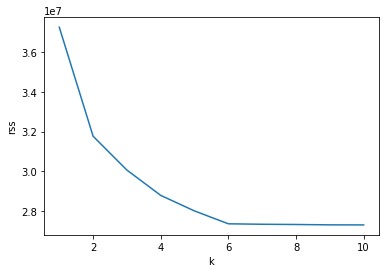

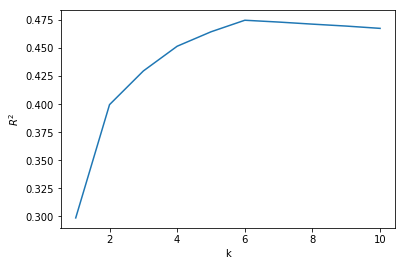

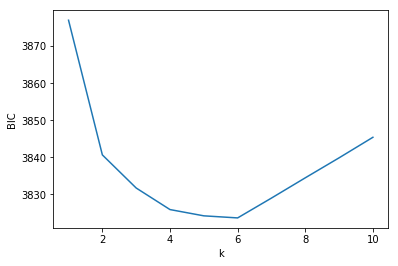

In [51]:
# Get best rss score for each subset
rss   = [min_rss(m)[1].ssr for m in model_subsets]

# Get best r-squared score for each subset
adjr2 = [max_adjr2(m)[1].rsquared_adj for m in model_subsets]
k     = np.arange(1, len(rss)+1)


# Get best BIC
def min_bic(statsmodels):
    """Return model with lowest R-squared"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].bic)[0]

bic = [min_bic(m)[1].bic for m in model_subsets]


ax = sns.lineplot(x=k, y=rss)
plt.xlabel('k')
plt.ylabel('rss')
plt.show()

sns.lineplot(x=k, y=adjr2)
plt.xlabel('k')
plt.ylabel('$R^2$')
plt.show()

sns.lineplot(x=k, y=bic)
plt.xlabel('k')
plt.ylabel('BIC')
plt.show()

The stats above seem to confer that a model with 6 predictors is best. But has each method chosen the same or similar models?

In [56]:
min_rss(model_subsets[5])[1].params

Intercept    90.238779
AtBat        -1.406741
Hits          5.990959
Walks         4.509466
CAtBat       -0.333623
CHits         1.329102
CHmRun        1.572294
dtype: float64

In [57]:
max_adjr2(model_subsets[5])[1].params

Intercept    90.238779
AtBat        -1.406741
Hits          5.990959
Walks         4.509466
CAtBat       -0.333623
CHits         1.329102
CHmRun        1.572294
dtype: float64

In [58]:
min_bic(model_subsets[5])[1].params

Intercept    90.238779
AtBat        -1.406741
Hits          5.990959
Walks         4.509466
CAtBat       -0.333623
CHits         1.329102
CHmRun        1.572294
dtype: float64

All three statisticis yield the same model for the subset with 6 predictors. This is expected for RSS and R-squared stats because they are related.

### 6.5.2 Forward and Backward Stepwise Selection